In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class NonineAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.food = 10
        self.metabolism = 3
        self.age = 0
        self.type = "Nonine"
        self.isAlive = True
        self.nextState = None

    def getEmptyCells(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells

    def reproduce(self, cellsToReproduce):
        randIndex = np.random.randint(0, len(cellsToReproduce)-1)
        cell = cellsToReproduce[randIndex]
        newAgent = NonineAgent(self.model.next_id(), self.model)
        self.model.grid.place_agent(newAgent, cell)
        self.model.schedule.add(newAgent)
    
    def randomMove(self, cellsToMove):
        randIndex = np.random.randint(0, len(cellsToMove)-1)
        cell = cellsToMove[randIndex]
        self.model.grid.move_agent(self, cell)
    
    def eat(self):
        foodToEat = 45 - self.food
        if foodToEat > self.model.grass[self.pos[0], self.pos[1]]:
            self.food += self.model.grass[self.pos[0], self.pos[1]]
            self.model.grass[self.pos[0], self.pos[1]] = 0
        else:
            self.food += foodToEat
            self.model.grass[self.pos[0], self.pos[1]] -= foodToEat

    def step(self):
        self.age += 1
        self.food -= self.metabolism
        if self.age > 25 or self.food <= 0:
            self.isAlive = False
            self.nextState = "Dead"
        else:
            self.nextState = "Alive"
        
        if self.isAlive:
            cellsToReproduce = self.getEmptyCells()
            if self.age >= 10 and self.food >= 40 and cellsToReproduce:
                flag = np.random.choice([0, 1])
                if flag == 1:
                    self.reproduce(cellsToReproduce)
            cellsToMove = self.getEmptyCells()
            if cellsToMove:
                self.randomMove(cellsToMove)
            if self.food < 45:
                self.eat()
        else:
            # remove agent from grid
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
    
    def advance(self):
        self.isAlive = self.nextState


In [3]:
class DeddianAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.food = 150
        self.metabolism = 2
        self.age = 0
        self.type = "Deddian"
        self.isAlive = True
        self.nextState = None

    def getEmptyCells(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        emptyCells = []
        for cell in neighbors:
            if self.model.grid.is_cell_empty(cell):
                emptyCells.append(cell)
        return emptyCells
    
    def getCellsWithNonines(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False)
        cellsWithNonine = []
        for cell in neighbors:
            if cell.type == "Nonine":
                cellsWithNonine.append(cell)
        return cellsWithNonine
        
    def reproduce(self, cellsToReproduce):
        randIndex = np.random.randint(0, len(cellsToReproduce)-1)
        cell = cellsToReproduce[randIndex]
        newAgent = DeddianAgent(self.model.next_id(), self.model)
        self.model.grid.place_agent(newAgent, cell)
        self.model.schedule.add(newAgent)
    
    def eat(self, cellsWithNonine):
        randIndex = np.random.randint(0, len(cellsWithNonine)-1)
        cell = cellsWithNonine[randIndex]
        nonine = self.model.grid.get_cell_list_contents(cell)[0]
        nonine.isAlive = False
        nonine.advance()
        self.food += 10
    
    def randomMove(self, cellsToMove):
        randIndex = np.random.randint(0, len(cellsToMove)-1)
        cell = cellsToMove[randIndex]
        self.model.grid.move_agent(self, cell)
        
    def step(self):
        self.age += 1
        self.food -= self.metabolism
        if self.age > 50 or self.food <= 0:
            self.isAlive = False
            self.nextState = "Dead"
        else:
            self.nextState = "Alive"
        
        if self.isAlive:
            cellsToReproduce = self.getEmptyCells()
            if self.age >= 10 and self.food >= 120 and cellsToReproduce:
                flag = np.random.choice([0, 1])
                if flag == 1:
                    self.reproduce(cellsToReproduce)
            
            cellsWithNonine = self.getCellsWithNonines()
            emptyCells = self.getEmptyCells()

            if self.food < 200 and cellsWithNonine:
                self.eat()
            elif emptyCells:
                self.randomMove(emptyCells)
        else:
            # remove agent from grid
            self.model.grid._remove_agent(self.pos, self)
            self.model.schedule.remove(self)
    
    def advance(self):
        self.isAlive = self.nextState
                
         

In [4]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for (content, x, y) in model.grid.coord_iter():
        if model.grid.is_cell_empty((x,y)):
            grid[x][y] = 0
        else:
            grid[x][y] = 1
    return grid

In [5]:
class PlanetModel(Model):
    def __init__(self, width= 35, height=35, nonines = 47, deddians = 15):
        self.grid = SingleGrid(width, height,True)
        self.schedule = SimultaneousActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.grass = np.zeros((width, height))
        self.grass += 20

        for i in range(nonines):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            while self.grid[x, y] != None:
                x = np.random.randint(0, width)
                y = np.random.randint(0, height)
            agent = NonineAgent(i, self)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)
        
        for i in range(deddians):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            while self.grid[x, y] != None:
                x = np.random.randint(0, width)
                y = np.random.randint(0, height)
            agent = DeddianAgent( nonines + i, self)
            self.grid.place_agent(agent, (x,y))
            self.schedule.add(agent)
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.grass += 1
        

        
        



In [6]:
GRID_SIZE = 35
NONINES = 47
DEDIANS = 15
ITERATIONS = 1

model = PlanetModel(GRID_SIZE, GRID_SIZE, NONINES, DEDIANS)
start_time = time.time()
for i in range(ITERATIONS):
    model.step()
print("Tiempo de ejecución: ", datetime.timedelta(seconds=time.time() - start_time))

Tiempo de ejecución:  0:00:00.009225


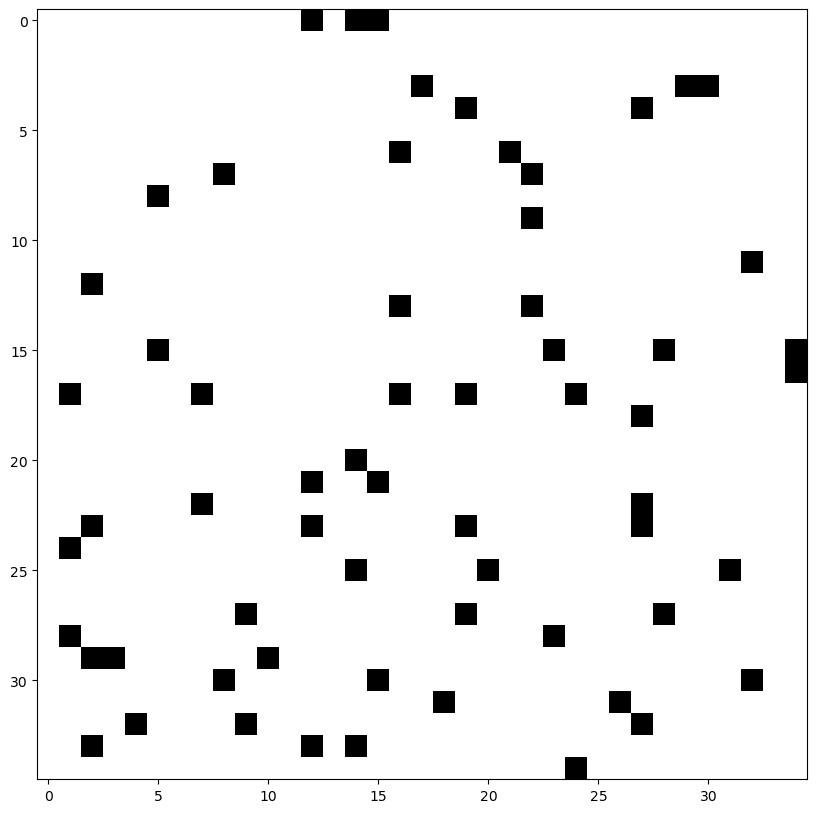

In [7]:
all_grid = model.datacollector.get_model_vars_dataframe()

fig, axs = plt.subplots(figsize=(10,10))
axs.set_xticks = ([])
axs.set_yticks = ([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig,animate,frames=ITERATIONS)
anim

: 

: 

: 

: 

: 